<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Ellipses-with-Shapely" data-toc-modified-id="Ellipses-with-Shapely-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Ellipses with Shapely</a></span></li><li><span><a href="#by-tile_id" data-toc-modified-id="by-tile_id-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>by tile_id</a></span></li><li><span><a href="#by-obsid" data-toc-modified-id="by-obsid-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>by obsid</a></span></li><li><span><a href="#Shapely-checks" data-toc-modified-id="Shapely-checks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Shapely checks</a></span></li></ul></div>

# Get easily clean code

For this to work install the conda package "black" and then do a `pip install nb_black` in a terminal. It auto-magically cleans up code in notebook cells. You can skip this now, if you are in a hurry, but install it at some point please.

In [1]:
import sys
if sys.platform == "darwin":  # michael's config
    # because Michael is using jupyter lab
    %load_ext lab_black
else:  # zade's config
    # because Zade is using jupyter notebook
    %load_ext nb_black

# Read fans and blotches (Do always)

The check for `darwin` is testing if things are run on a Mac. As you don't do that so far, this test is fine. If you would start working on a Mac, we would need to be more specific and check for the computer name, but for now this should work fine.

In [2]:
from my_io import get_fans_blotches

In [3]:
fans, blotches = get_fans_blotches()

## GUI backend choice

If `%matplotlib widget` doesn't work, use `%matplotlib inline`

In [4]:
%matplotlib widget

# Ellipses with Shapely 

## by tile_id

In [5]:
import geopandas as gp
import shapely
from planet4 import io, markings

In [6]:
id_ = "bdb"

In [7]:
blotches_per_id = blotches[blotches.tile_id == io.check_and_pad_id(id_)]

fans_per_id = fans[fans.tile_id == io.check_and_pad_id(id_)]

In [8]:
gs_blotch = gp.GeoSeries(
    [markings.Blotch(row).to_shapely() for _, row in blotches_per_id.iterrows()]
)

gs_fans = gp.GeoSeries(
    [markings.Fan(row).to_shapely() for _, row in fans_per_id.iterrows()]
)

In [9]:
gs = pd.concat([gs_blotch, gs_fans], ignore_index=True, sort=True)

In [10]:
gs.head()

0    POLYGON ((479.062220807226 431.3457568066383, ...
1    POLYGON ((155.3051658836881 472.8084264553739,...
2    POLYGON ((211.6192116049175 550.8363739068183,...
3    POLYGON ((633.2858484015004 138.7152215327977,...
4    POLYGON ((-2.658795681296709 245.5861936207943...
dtype: object

In [11]:
p4id = markings.TileID(id_)

In [12]:
p4id.plot_fans(data=fans_per_id)
ax = plt.gca()
p4id.plot_blotches(data=blotches_per_id, ax=ax)

FigureCanvasNbAgg()

In [13]:
gs.plot()
ax = plt.gca()
ax.set_xlim((0, markings.IMG_X_SIZE))
ax.set_ylim((0, markings.IMG_Y_SIZE))
ax.invert_yaxis()  # b/c image plots are upside down in MPL

FigureCanvasNbAgg()

In [14]:
gs.head()

0    POLYGON ((479.062220807226 431.3457568066383, ...
1    POLYGON ((155.3051658836881 472.8084264553739,...
2    POLYGON ((211.6192116049175 550.8363739068183,...
3    POLYGON ((633.2858484015004 138.7152215327977,...
4    POLYGON ((-2.658795681296709 245.5861936207943...
dtype: object

In [15]:
unionized = gs.unary_union

In [16]:
import seaborn as sns

sns.set_context("notebook")

In [17]:
squared_pixel_scale = fans.map_scale.iloc[0] ** 2
squared_pixel_scale

0.0625

In [18]:
fans.map_scale.iloc[0]

0.25

In [19]:
unionized.area

121734.84317124919

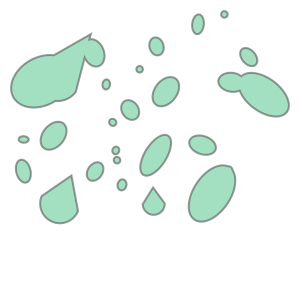

In [20]:
unionized

In [21]:
area = unionized.area * squared_pixel_scale
area

7608.427698203074

In [22]:
pixel_area = markings.IMG_X_SIZE * markings.IMG_Y_SIZE
tile_area = pixel_area * squared_pixel_scale
tile_area

34020.0

In [23]:
fraction = area / tile_area
fraction

0.22364572893013152

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 5), constrained_layout=True)
p4id.plot_fans(data=fans_per_id, ax=ax[0])
p4id.plot_blotches(data=blotches_per_id, ax=ax[0])
# p4id.show_subframe(ax=ax[1])
gp.GeoSeries(unionized).boundary.plot(ax=ax[1])
ax[1].set_xlim(-25, markings.IMG_X_SIZE + 25)
ax[1].set_ylim(markings.IMG_Y_SIZE + 25, -25)

ax[1].set_axis_off()
fig.suptitle(id_)
ax[0].set_title("Combined fans and blotches")
ax[1].set_title(
    f"Union out of shapely fans and blotches.\nArea: {area:.0f} $m^2$; Fraction: {fraction*100:.0f} %"
)
fig.savefig("shapely_both.png", dpi=100)

FigureCanvasNbAgg()

In [25]:
df1 = gp.GeoDataFrame({"geometry": gs})
df1.head()

,geometry
0,"POLYGON ((479.062220807226 431.3457568066383, ..."
1,"POLYGON ((155.3051658836881 472.8084264553739,..."
2,"POLYGON ((211.6192116049175 550.8363739068183,..."
3,"POLYGON ((633.2858484015004 138.7152215327977,..."
4,POLYGON ((-2.658795681296709 245.5861936207943...


In [26]:
inters = gp.overlay(df1, df1, how="intersection")
inters.plot()

FigureCanvasNbAgg()

# by obsid

In [27]:
fans_per_id.columns

Index(['marking_id', 'angle', 'distance', 'tile_id', 'image_x', 'image_y',
       'n_votes', 'obsid', 'spread', 'version', 'vote_ratio', 'x', 'y',
       'x_angle', 'y_angle', 'l_s', 'map_scale', 'north_azimuth',
       'BodyFixedCoordinateX', 'BodyFixedCoordinateY', 'BodyFixedCoordinateZ',
       'PlanetocentricLatitude', 'PlanetographicLatitude', 'Longitude'],
      dtype='object')

In [28]:
fans_per_id.l_s.value_counts()

242.279    5
Name: l_s, dtype: int64

In [29]:
fans_per_id.obsid.unique()

array(['ESP_012643_0945'], dtype=object)

In [30]:
obsid = "ESP_012643_0945"
obsid = "ESP_013049_0950"
# obsid = 'ESP_011447_0950'

In [31]:
fans[fans.obsid.map(lambda x: x.endswith("_0950"))].obsid.value_counts()

ESP_020146_0950    2687
ESP_020357_0950    2526
ESP_020476_0950    2081
ESP_020568_0950    1934
ESP_020779_0950    1295
ESP_021491_0950    1151
ESP_020150_0950     879
ESP_012212_0950     825
ESP_011448_0950     742
ESP_011447_0950     707
ESP_012693_0950     684
ESP_013049_0950     621
ESP_011843_0950     526
ESP_011777_0950     479
ESP_020401_0950     450
ESP_012838_0950     437
ESP_012344_0950     298
ESP_011921_0950     263
ESP_012753_0950     260
ESP_012265_0950     223
ESP_013260_0950     216
ESP_012845_0950     202
ESP_020480_0950     148
ESP_021482_0950      76
ESP_020783_0950      65
ESP_020902_0950      64
ESP_011348_0950       4
ESP_022193_0950       1
Name: obsid, dtype: int64

In [32]:
fans_obsid = fans.query("obsid == @obsid")
blotches_obsid = blotches.query("obsid == @obsid")

In [33]:
fans_obsid.l_s.value_counts()

262.343    621
Name: l_s, dtype: int64

In [34]:
fans_obsid.tile_id.nunique()

68

In [35]:
gs_blotch = gp.GeoSeries(
    [
        markings.Blotch(row, scope="hirise").to_shapely()
        for _, row in blotches_obsid.iterrows()
    ]
)

gs_fans = gp.GeoSeries(
    [
        markings.Fan(row, scope="hirise").to_shapely()
        for _, row in fans_obsid.iterrows()
    ]
)

In [36]:
gs = pd.concat([gs_blotch, gs_fans], ignore_index=True, sort=True)

In [37]:
gs.shape

(1091,)

Here was the error before. Read on to learn how I debugged further.

In [38]:
unioned = gs.unary_union

# Shapely checks

In [40]:
import pandas as pd

In [41]:
fan1 = markings.Fan(
    pd.Series(
        {"x": 100.0, "y": 200.0, "angle": 0, "spread": 10, "distance": 100}
    )
)
fan1

markings.Fan object. Input data:
base: [100. 200.]
armlength: 92.30623464972037
arm1: [191.95498156 191.95498156]
arm2: [191.95498156 208.04501844]

### Task List

* [x] create a fan with the same base point but rotated off.  
* [x] Make sure that so long as base points are the same but rotated (eg 180 degrees) it's valid. I think it will be so long as only one point touches.
* [x] create fans, mess with floating points and rotating the fans, see if base points with floating points, different angles work.
* [x] see if unary unions work for rotated fans.  Don't use geoseries, just use shapelys normal unary unions

In [42]:
fan2 = markings.Fan(
    pd.Series(
        {"x": 100.0, "y": 200.0, "angle": 5, "spread": 10, "distance": 100}
    )
)

In [43]:
fan1_shape = fan1.to_shapely()
fan2_shape = fan2.to_shapely()

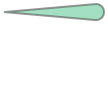

In [44]:
fan1_shape

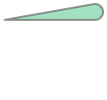

In [45]:
fan2_shape

True


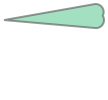

In [46]:
newfan = fan1_shape.union(fan2_shape)
print(newfan.is_valid)
newfan

In [47]:
from shapely.ops import unary_union

In [48]:
unary_union([fan1_shape, fan2_shape]).is_valid

True

I have reduced the tests to the minimum showing that the basic principle works.

> This being valid shows that even with an almost complete intersection, unionizing them makes them valid.

I don't understand what you mean here, because each single shape is already valid?
However, it is good to see that almost completely overlapping fans with the same base point do not create a problem per se.

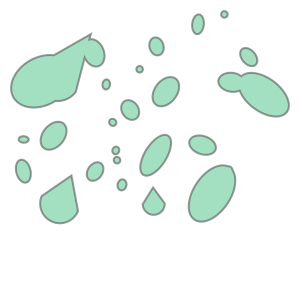

In [49]:
# perhaps unary unions are different
unionized

In [50]:
unionized.is_valid

True

>  this shows that the unionized object we have for our one tile is valid and should not throw our error.

Yes, that's good to see.

In [51]:
# continuing obsid checks:
fans.columns

Index(['marking_id', 'angle', 'distance', 'tile_id', 'image_x', 'image_y',
       'n_votes', 'obsid', 'spread', 'version', 'vote_ratio', 'x', 'y',
       'x_angle', 'y_angle', 'l_s', 'map_scale', 'north_azimuth',
       'BodyFixedCoordinateX', 'BodyFixedCoordinateY', 'BodyFixedCoordinateZ',
       'PlanetocentricLatitude', 'PlanetographicLatitude', 'Longitude'],
      dtype='object')

In [52]:
# obsid = 'ESP_012643_0945'
obsid = "ESP_013049_0950"
# obsid = 'ESP_011447_0950'

In [53]:
fans[fans.obsid.map(lambda x: x.endswith("_0950"))].obsid.value_counts()

ESP_020146_0950    2687
ESP_020357_0950    2526
ESP_020476_0950    2081
ESP_020568_0950    1934
ESP_020779_0950    1295
ESP_021491_0950    1151
ESP_020150_0950     879
ESP_012212_0950     825
ESP_011448_0950     742
ESP_011447_0950     707
ESP_012693_0950     684
ESP_013049_0950     621
ESP_011843_0950     526
ESP_011777_0950     479
ESP_020401_0950     450
ESP_012838_0950     437
ESP_012344_0950     298
ESP_011921_0950     263
ESP_012753_0950     260
ESP_012265_0950     223
ESP_013260_0950     216
ESP_012845_0950     202
ESP_020480_0950     148
ESP_021482_0950      76
ESP_020783_0950      65
ESP_020902_0950      64
ESP_011348_0950       4
ESP_022193_0950       1
Name: obsid, dtype: int64

In [54]:
fans_obsid = fans.query("obsid == @obsid")
blotches_obsid = blotches.query("obsid == @obsid")

In [55]:
fans_obsid.l_s.value_counts()

262.343    621
Name: l_s, dtype: int64

In [56]:
fans_obsid.tile_id.nunique()

68

In [57]:
gs_blotch = gp.GeoSeries(
    [
        markings.Blotch(row, scope="hirise").to_shapely()
        for _, row in blotches_obsid.iterrows()
    ]
)

gs_fans = gp.GeoSeries(
    [
        markings.Fan(row, scope="hirise").to_shapely()
        for _, row in fans_obsid.iterrows()
    ]
)

gs = pd.concat([gs_blotch, gs_fans], ignore_index=True, sort=True)

gs.shape

(1091,)

In [61]:
unioned = gs.unary_union 
#error in GEOS, unresolved : https://github.com/Toblerity/Shapely/issues/47


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 1321.0404031739024 466.44991522170005 at 1321.0404031739024 466.44991522170005


ValueError: No Shapely geometry can be created from null value

In [58]:
gs.is_valid.count() == gs.count()  # every individual object is also valid

True

## Nice idea!
Checking the validity of each object is indeed a very good idea. Unfortunately, the pandas method's `count` implementation caught you bad, b/c it's supressing the False counts. See it's definition, and not the `non-NA/null` requirement. This prevents False values from being counted:

In [59]:
gs.count?

Signature: gs.count(level=None)
Docstring:
Return number of non-NA/null observations in the Series

Parameters
----------
level : int or level name, default None
    If the axis is a MultiIndex (hierarchical), count along a
    particular level, collapsing into a smaller Series

Returns
-------
nobs : int or Series (if level specified)
File:      ~/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/series.py
Type:      method


The safe way to check this is to use the `value_counts` method (NOTE: Even that one is removing NAN values, sometimes one needs to know their presence as well, then you can use the keyword `dropna=False`)

In [64]:
gs.is_valid.value_counts()

True     1086
False       5
dtype: int64

In [65]:
gs.is_valid.value_counts(dropna=False)

True     1086
False       5
dtype: int64

No difference, so there are no NANs. But nevertheless, THIS is the clue!

Maybe these are the bad guys stopping us from working... Let's filter them out, before we look why they are bad.

In [60]:
gs_filtered = gs[gs.is_valid]

In [67]:
gs_filtered.shape

(1086,)

In [68]:
gs.shape

(1091,)

In [69]:
unioned = gs_filtered.unary_union

**EUREKA! A working union!**

Now, let's find out why 5 are invalid.

In [70]:
broken = gs[~gs.is_valid]  # note the ~, which is the logical invert operator

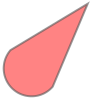

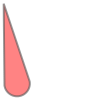

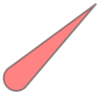

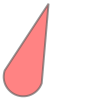

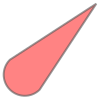

In [71]:
for item in broken:
    item

Ok, all broken items are fans. So maybe my fan to shapely generator does something bad?

BTW, I just noticed that the shapely object display is **RED** when it's invalid, and **GREEN** when it's valid, how cool is that:

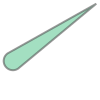

In [72]:
gs_filtered.iloc[-1]

For further debugging I now need the Fans that are broken as shapely objects, so I catch them in a similar loop as used for creating `gs_fans`:

In [77]:
fan_objects = [
    markings.Fan(row, scope="hirise") for _, row in fans_obsid.iterrows()
]

In [78]:
broken_fans = [fan for fan in fan_objects if not fan.to_shapely().is_valid]

In [79]:
len(broken_fans)

5

In [85]:
fan = broken_fans[0]

In [90]:
arr = np.array(fan.to_shapely().boundary)

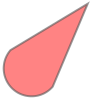

In [87]:
fan.to_shapely()

In [95]:
from shapely.geometry import Polygon

In [114]:
arr2 = pd.DataFrame(arr).drop_duplicates().values

In [115]:
arr.shape

(103, 2)

In [123]:
df = pd.DataFrame(arr2)

In [130]:
df.iloc[0].values

array([ 988.08976965, 2781.0379509 ])

In [131]:
df.iloc[-1].values

array([ 988.08976965, 2781.0379509 ])

In [142]:
with np.printoptions(precision=14):
    print(df.iloc[0].values)
    print(df.iloc[-1].values)

[ 988.089769654634  2781.0379509006934]
[ 988.0897696546342 2781.037950900694 ]


Ok, so this little difference prevents it from being a formal duplicate, but apparently it is a duplicate for shapely.Polygon, rendering the Polygon invalid.

Because our pixel marking precision is anyhow maximally on a pixel level, it's fine to round to 1 or 2 decimal values and **then** drop the duplicates.

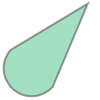

In [156]:
Polygon(df.round(1).drop_duplicates().values)

Yay! Implementing it now into my shapely creator method:

In [158]:
gs_blotch = gp.GeoSeries(
    [
        markings.Blotch(row, scope="hirise").to_shapely()
        for _, row in blotches_obsid.iterrows()
    ]
)

gs_fans = gp.GeoSeries(
    [
        markings.Fan(row, scope="hirise").to_shapely()
        for _, row in fans_obsid.iterrows()
    ]
)

gs = pd.concat([gs_blotch, gs_fans], ignore_index=True, sort=True)

gs.shape

(1091,)

In [159]:
unionized = gs.unary_union

In [160]:
unionized.area

892621.4299896038

# New Function

In [ ]:
import pandas as pd
from planet4 import io
import geopandas as gp
import numpy as np
import shapely
from planet4 import markings
from shapely.ops import unary_union
from shapely.geometry import Polygon

In [6]:
#new function that creates a polygon out of fans/blotches, break up get_tile_fraction into one that finds fraction,
#as well as one that creates polygons for fans, blotches, and mixed.
#make get tile fraction call that function
#make getobsid to call the polygon function

#run loop through every tile on its own,dont use counters, can look at dictionary stuff too! 
#then try to get obsid % coverage

In [161]:
bucket = []
for tile_id in all_tiles:
    d = {}
    d['tile_id'] = tile_id
    d['result'] = get_tile_fraction(tile_id)
    bucket.append(d)

NameError: name 'all_tiles' is not defined

In [173]:
def get_polygon(tile_id, scope="hirise", mix="Both"):
    """Retrieve the union-ed polygon of all objects for one tile_id
    
    Parameters
    ----------
    tile_id : str
        The Planet Four tile_id
    scope : {'hirise', 'planet4'}, optional
        Switch to control if coordinates used for objects are those for the tile or
        for the HiRISE images in which the given tile_id is located in.
        Default: 'hirise'
    mix : {'Mixed', 'Blotch', 'Fans'}, optional
        Switch to control if only Blotches, only Fans or both will be combined.
        Default: 'Mixed' (meaning both)
    """
    id_ = tile_id
    blotch = blotches[blotches.tile_id == io.check_and_pad_id(id_)]
    fan = fans[fans.tile_id == io.check_and_pad_id(id_)]
    gs_blotch = gp.GeoSeries(
        [
            markings.Blotch(row, scope).to_shapely()
            for _, row in blotch.iterrows()
        ]
    )
    gs_fans = gp.GeoSeries(
        [markings.Fan(row, scope).to_shapely() for _, row in fan.iterrows()]
    )
    if mix.startswith("Both") or mix.startswith("Mix"):
        gs = pd.concat([gs_blotch, gs_fans], ignore_index=True, sort=True)
    elif mix.startswith("Blotch"):
        gs = gs_blotch
    elif mix.startswith("Fan"):
        gs = gs_fans
    else:
        return "Please enter Mix, Blotch, or Fans for 'mix' value"
    return gs.unary_union

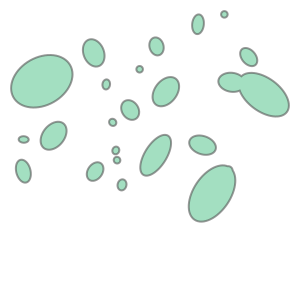

In [174]:
get_polygon("bdb", mix="Blotch")

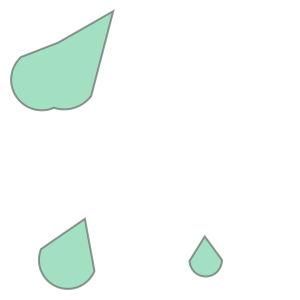

In [175]:
get_polygon("bdb", mix="Fan")

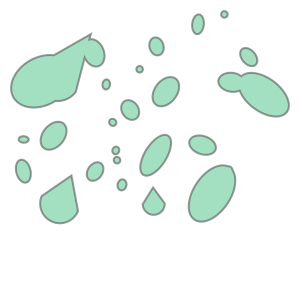

In [177]:
get_polygon("bdb", mix="Both")

In [20]:
def get_tile_fraction(tile_id, scope = 'hirise', mix = 'Mixed'):
    id_ = tile_id
    blotch = blotches[blotches.tile_id == io.check_and_pad_id(id_)]
    fan = fans[fans.tile_id == io.check_and_pad_id(id_)]
    gs_blotch = gp.GeoSeries([markings.Blotch(row, scope).to_shapely() for _,row in blotch.iterrows()])
    gs_fans = gp.GeoSeries([markings.Fan(row, scope).to_shapely() for _,row in fan.iterrows()])
    squared_pixel_scale = fans.map_scale.iloc[0]**2
    pixel_area = markings.IMG_X_SIZE * markings.IMG_Y_SIZE
    if mix == 'Mixed':
        gs = pd.concat([gs_blotch, gs_fans], ignore_index=True, sort=True)
        unionized = gs.unary_union
        area = unionized.area * squared_pixel_scale
        tile_area = pixel_area * squared_pixel_scale
        fraction = area / tile_area
        return fraction
    if mix == 'Blotch':
        unionized_b = gs_blotch.unary_union
        area_b = unionized_b.area * squared_pixel_scale
        tile_area_b = pixel_area * squared_pixel_scale
        fraction_b = area_b / tile_area_b
        return fraction_b
    if mix == 'Fans':
        unionized_f = gs_fans.unary_union
        area_f = unionized_f.area * squared_pixel_scale
        tile_area_f = pixel_area * squared_pixel_scale
        fraction_f = area_f / tile_area_f
        return fraction_f
    else:
        return "Please enter Mix, Blotch, or Fans for 'mix' value"
    

In [ ]:
get_tile_fraction('bdb', mix = 'Blotch') +get_tile_fraction('bdb', mix = 'Fans') 

In [ ]:
get_tile_fraction('bdb', mix = 'Blotch')

In [ ]:
get_tile_fraction('bdb', mix = 'Fans')

In [ ]:
get_tile_fraction('bdb')

In [ ]:
#fan obsid values, unique
f_o_v = np.unique(fans.obsid.values)

In [11]:
obsid_test = 'ESP_012079_0945'

In [12]:
obsid_test

'ESP_012079_0945'

In [13]:
fans_obsid = fans.query('obsid == @obsid_test').tile_id.unique()

In [14]:
blotch_obsid = blotches.query('obsid == @obsid_test').tile_id.unique()

In [15]:
mixed_obsid = np.concatenate((fans_obsid, blotch_obsid))

In [16]:
all_tiles = np.unique((mixed_obsid))

In [ ]:
len(all_tiles)

In [ ]:
#just loop over all tiles in all_tiles with my get_tile_fraction function
for i in len(all_tiles):
    get_tile_fraction(i)

In [ ]:
tile_id = all_tiles[0]

In [ ]:
#the check and pad id fits the first bit of the tile id in front of the last few digits, doesn't matter for us when we collect
#full legal IDs as he showed above.
for tile_id in all_tiles:
    test_blotches = blotches.query('tile_id == @tile_id')

In [ ]:
test_blotches

In [ ]:
test_blotches = blotches.query('tile_id == @tile_id')
test_blotches

In [ ]:
def get_obsid_fraction(the_obsid, scope = 'hirise'): #add fans vs blotches vs mixed later
    test_array = []
    squared_pixel_scale = fans.map_scale.iloc[0]**2
    pixel_area = markings.IMG_X_SIZE * markings.IMG_Y_SIZE
    if np.any(fans.obsid.values[:]) == the_obsid or np.any(blotches.obsid.values[:]) == the_obsid:
        test_array.append(fans.tile_id)
        test_array.append(blotches.tile_id)
    
    
    
    #return test_array #shows test array is working, but when I make unique get new error.
    u_test_array = np.unique(test_array, return_index = False)
    #u_test_array = u_test_array.reset_index(drop=True)
    #return u_test_array
    
    poly = Polygon() #creates an empty polygon to union with
    for tile_id in test_array:
        blotch = blotches[blotches.tile_id == tile_id]
        gs_blotch = gp.GeoSeries([markings.Blotch(row, scope).to_shapely() for _, row in blotch.iterrows])
        gs_fans = gp.GeoSeries([markings.Fan(row, scope).to_shapely() for _,row in fan.iterrows()])
        gs = pd.concat([gs_blotch, gs_fans], ignore_index=True, sort=True)
        unionized = gs.unary_union
        x = unionized.union(poly)
        #add x to poly 'catch the result' 
        
    area = poly.area * squared_pixel_scale
    tile_area = pixel_area * squared_pixel_scale #need obsid area, not tile area- how to do this?
    fraction = area / tile_area
    return fraction

In [ ]:
get_obsid_fraction(obsid_test)

In [ ]:
get_obsid_fraction(obsid_test)